# Importações

In [ ]:
from imagem import Imagem
import Functions as fc
from glob import glob
import numpy as np
from skimage.io import imread,imshow,imsave,imread_collection
import cv2
from skimage.exposure import equalize_hist
from skimage.filters import median
from IPython.display import clear_output
from tqdm import tqdm
import seaborn as sns
import time
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import pandas as pd
from skimage.transform import resize

import tensorflow as tf
 
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model



from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Abertura dos Arquivos

In [ ]:
originais = sorted(glob(f'/content/drive/MyDrive/flowers(novas)/*/*', recursive=True))

imgs = {
    'daisy': sorted(glob(f'/content/drive/MyDrive/flowers(novas)/daisy/*', recursive=True)),
    'dandelion': sorted(glob(f'/content/drive/MyDrive/flowers(novas)/dandelion/*', recursive=True)),
    'rose': sorted(glob(f'/content/drive/MyDrive/flowers(novas)/rose/*', recursive=True)),
    'sunflower': sorted(glob(f'/content/drive/MyDrive/flowers(novas)/sunflower/*', recursive=True)),
    'tulip': sorted(glob(f'/content/drive/MyDrive/flowers(novas)/tulip/*', recursive=True))
}

# Pré-Processamento

In [ ]:
def poeInt(imagem):
    linhas, colunas = imagem.shape
    copy = np.zeros((linhas, colunas), dtype=np.uint8)
    for l in range(linhas):
        for c in range(colunas):
                if imagem[l][c] == True:
                    copy[l][c] = 255
    return copy

In [ ]:
def lerTodos(originais):
    imgs = []
    for i in tqdm(originais, desc='Imagens:  '):
        img = Imagem(i)
        img.ler()
        img.filtros['eq'] = img.equalize()
        img.filtros['median'] = median(img.filtros['eq'])
        imgs.append(img)
    
    return imgs

In [ ]:
def subtraiCamada(img, camada='b'):
    img0 = img.filtros['median'].copy()
    img0 = img0/255
    img0 = img0[:,:,0] + img0[:,:,1] + img0[:,:,2]

    img1 = img.filtros['otsu'][camada].copy()
    img1 = img1/255

    img0[~img1.astype(bool)] = 0
    
    return img0

In [ ]:
def subtrai(imgs):
    for i in tqdm(imgs, desc='Otsu:  '):
        i.filtros['otsu'] = {
            'r': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,0])),
            'g': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,1])),
            'b': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,2]))
        }

        i.filtros['inteiro'] = i.inteiro()

        i.filtros['normalize'] = i.normalize()

        i.filtros['sub'] = {
            'r': subtraiCamada(i, 'r'),
            'g': subtraiCamada(i, 'g'),
            'b': subtraiCamada(i, 'b')
        }

        """ 
            Fazer a subtração dos canais de cor com o otsu.     
        """
    
    return imgs

In [ ]:
imagens = lerTodos(originais)

Imagens:  : 100%|██████████| 500/500 [02:26<00:00,  3.42it/s]


In [ ]:
imagens = subtrai(imagens)

Otsu:  : 100%|██████████| 500/500 [02:44<00:00,  3.04it/s]


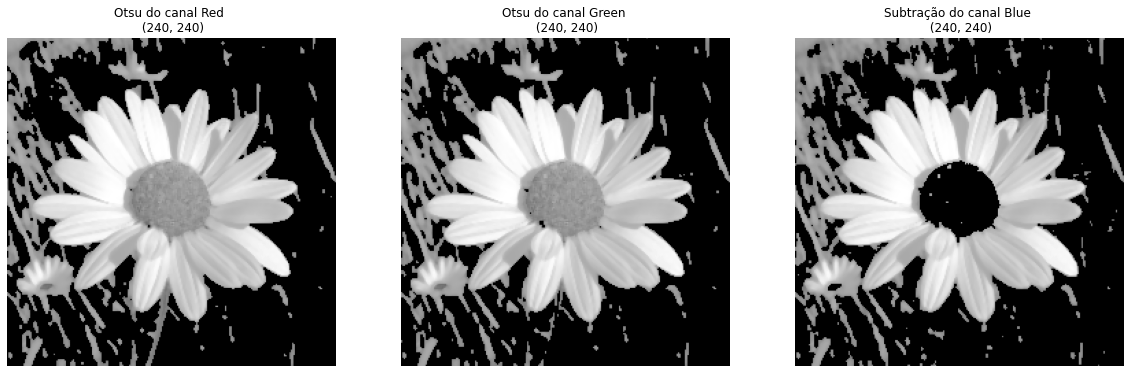

In [ ]:
ind = 9
Imagem.manyShowWithTitle(
    {'img': imagens[ind].filtros['otsu']['r'], 'title': 'Otsu do canal Red'},
    {'img': imagens[ind].filtros['sub']['r'], 'title': 'Otsu do canal Red'},
    {'img': imagens[ind].filtros['sub']['g'], 'title': 'Otsu do canal Green'},
    {'img': imagens[ind].filtros['sub']['b'], 'title': 'Subtração do canal Blue'},
)


In [ ]:
auxR = [ imagens[x].filtros['sub']['b'] for x in range(len(imagens)) ]
auxG = [ imagens[x].filtros['sub']['g'] for x in range(len(imagens)) ]
auxB = [ imagens[x].filtros['sub']['r'] for x in range(len(imagens)) ]

In [ ]:
red = imread_collection(sorted(glob(f'/content/drive/MyDrive/subs/red/*/*', recursive=True)))
green = imread_collection(sorted(glob(f'/content/drive/MyDrive/subs/green/*/*', recursive=True)))
blue = imread_collection(sorted(glob(f'/content/drive/MyDrive/subs/blue/*/*', recursive=True)))

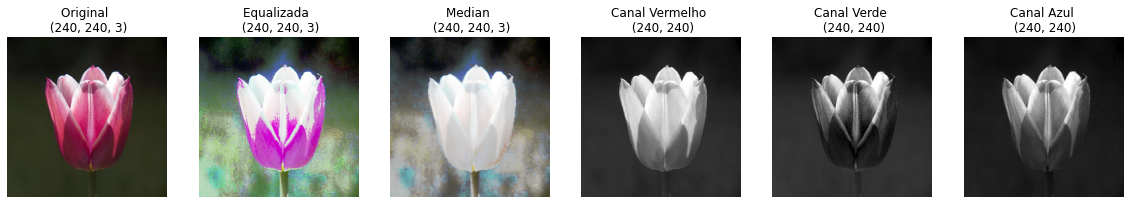

In [ ]:
imagens[440].shows(5)

In [ ]:
labels = []
labelsInt = []
k = 0
for j in ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']:
    for i in range(100):
        labels.append(j)
        labelsInt.append(k)
    k += 1

# Descritores

In [ ]:
imagens[440].filtros.keys()

dict_keys(['eq', 'median', 'otsu', 'inteiro', 'normalize', 'sub'])

In [ ]:
models = [
    MobileNet(weights="imagenet", input_shape=(224, 224, 3), include_top=False),
    DenseNet121(weights="imagenet", input_shape=(224, 224, 3), include_top=False),
    VGG16(weights="imagenet", input_shape=(224, 224, 3), include_top=False),
    VGG19(weights="imagenet", input_shape=(224, 224, 3), include_top=False),
    ResNet50(weights="imagenet", input_shape=(224, 224, 3), include_top=False)
]

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
def treina(imgs, desc = ''):
  img2 = np.zeros((1,224,224,3))
  img2[0, :, :, :] = imgs[:,:,:3]
  return img2

In [ ]:
def montaClasse(imgs):
  count = 0
  result = []
  classe = []
  for i in range(len(imgs)):
    red = resize(imgs[i].filtros['median'], (224, 224))
    result.append(red)
    count += 1

  return result

In [ ]:
for model in models:
  model_name = model.name
  print(f'Running model {model_name}')
  model = tf.keras.models.Sequential(
      [
          model,
          tf.keras.layers.GlobalAveragePooling2D()
      ]
  )

  features = []
  classes = montaClasse(imagens)

  count = 0

  for index, i in enumerate(classes):
    img2 = treina(i)
    features.append(np.append(model.predict(img2, verbose=0)[0], [count]))
    if index % 100 == 0 and index != 0:
      count += 1


  np.savetxt(f'/content/drive/MyDrive/topicos_csv/{model_name}.csv', features, delimiter=',')

Running model mobilenet_1.00_224
Running model densenet121
Running model vgg16
Running model vgg19
Running model resnet50


# Classificadores

In [ ]:
def classificationForest(X,y, t=0.9):
    """ com random forest """
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t, random_state=42, shuffle=True)
    # criar instancia do classificador
    clf = RandomForestClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    f1 = f1_score(y_test, pred, average="micro")
    precision = precision_score(y_test, pred, average="micro")
    #auc = roc_auc_score(y_test, pred)
    kappa = cohen_kappa_score(y_test, pred)

    return {
        'acc': acuracia,
        'f1': f1,
        'precision': precision,
        'kappa': kappa
    }

In [ ]:
def classificationXBR(X, y, t=0.9):
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t, random_state=42, shuffle=True)
    # criar instancia do classificador
    clf = xgb.XGBClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    f1 = f1_score(y_test, pred, average="micro")
    precision = precision_score(y_test, pred, average="micro")
    #auc = roc_auc_score(y_test, )
    kappa = cohen_kappa_score(y_test, pred)


    return {
        'acc': acuracia,
        'f1': f1,
        'precision': precision,
        'kappa': kappa
    }

In [ ]:
rf_results = {}
xbr_results = {}
for model in models:
  model_name = model.name

  features_df = pd.read_csv(f'/content/drive/MyDrive/topicos_csv/{model_name}.csv', header=None)
  features_df.dropna(inplace=True)

  X = features_df.iloc[:,:-1]
  y = features_df.iloc[:, -1]



  rf_results[model_name] = classificationForest(X, y, t=0.7)
  xbr_results[model_name] = classificationXBR(X, y, t=0.7)

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.0,0.0,0.005422,0.0,1.139269,0.0,0.0,0.851881,0.003134,0.0,...,0.0,0.0,0.0,0.021800,0.0,0.0,2.400331,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,1.311819,0.0,0.0,0.997239,0.030901,0.0,...,0.0,0.0,0.0,0.028402,0.0,0.0,2.139850,0.0,0.0,0.0
2,0.0,0.0,0.004047,0.0,1.292301,0.0,0.0,0.835603,0.006734,0.0,...,0.0,0.0,0.0,0.013701,0.0,0.0,2.068009,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,1.364931,0.0,0.0,0.936959,0.009087,0.0,...,0.0,0.0,0.0,0.044651,0.0,0.0,1.935092,0.0,0.0,0.0
4,0.0,0.0,0.004840,0.0,1.447693,0.0,0.0,0.937413,0.027474,0.0,...,0.0,0.0,0.0,0.043729,0.0,0.0,2.145995,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.000000,0.0,1.303635,0.0,0.0,1.041070,0.008312,0.0,...,0.0,0.0,0.0,0.075801,0.0,0.0,2.271266,0.0,0.0,4.0
496,0.0,0.0,0.006618,0.0,1.374338,0.0,0.0,1.004770,0.025421,0.0,...,0.0,0.0,0.0,0.056075,0.0,0.0,2.309471,0.0,0.0,4.0
497,0.0,0.0,0.000000,0.0,1.355711,0.0,0.0,0.960747,0.038205,0.0,...,0.0,0.0,0.0,0.030209,0.0,0.0,2.217013,0.0,0.0,4.0
498,0.0,0.0,0.002524,0.0,1.363428,0.0,0.0,1.044717,0.015930,0.0,...,0.0,0.0,0.0,0.064941,0.0,0.0,2.187726,0.0,0.0,4.0


In [ ]:
rf_results

{'mobilenet_1.00_224': {'acc': 0.96,
  'f1': 0.96,
  'precision': 0.96,
  'kappa': 0.9495628782784129},
 'densenet121': {'acc': 0.9533333333333334,
  'f1': 0.9533333333333334,
  'precision': 0.9533333333333334,
  'kappa': 0.9412948674941295},
 'vgg16': {'acc': 0.9133333333333333,
  'f1': 0.9133333333333333,
  'precision': 0.9133333333333333,
  'kappa': 0.8908785674314493},
 'vgg19': {'acc': 0.8733333333333333,
  'f1': 0.8733333333333333,
  'precision': 0.8733333333333333,
  'kappa': 0.8408621363560221},
 'resnet50': {'acc': 0.4866666666666667,
  'f1': 0.4866666666666667,
  'precision': 0.4866666666666667,
  'kappa': 0.3623364434384144}}

In [ ]:
xbr_results

{'mobilenet_1.00_224': {'acc': 0.92,
  'f1': 0.92,
  'precision': 0.92,
  'kappa': 0.8991991935935487},
 'densenet121': {'acc': 0.94,
  'f1': 0.94,
  'precision': 0.94,
  'kappa': 0.9246104875188474},
 'vgg16': {'acc': 0.9066666666666666,
  'f1': 0.9066666666666666,
  'precision': 0.9066666666666666,
  'kappa': 0.8824319785018475},
 'vgg19': {'acc': 0.8666666666666667,
  'f1': 0.8666666666666667,
  'precision': 0.8666666666666667,
  'kappa': 0.8330272165637002},
 'resnet50': {'acc': 0.5533333333333333,
  'f1': 0.5533333333333333,
  'precision': 0.5533333333333333,
  'kappa': 0.44293553572418387}}

In [ ]:
pd.DataFrame(rf_results)

,mobilenet_1.00_224,densenet121,vgg16,vgg19,resnet50
acc,0.960000,0.953333,0.913333,0.873333,0.486667
f1,0.960000,0.953333,0.913333,0.873333,0.486667
precision,0.960000,0.953333,0.913333,0.873333,0.486667
kappa,0.949563,0.941295,0.890879,0.840862,0.362336


In [ ]:
pd.DataFrame(xbr_results)

,mobilenet_1.00_224,densenet121,vgg16,vgg19,resnet50
acc,0.920000,0.94000,0.906667,0.866667,0.553333
f1,0.920000,0.94000,0.906667,0.866667,0.553333
precision,0.920000,0.94000,0.906667,0.866667,0.553333
kappa,0.899199,0.92461,0.882432,0.833027,0.442936
